# Reading data

In [1]:
import numpy as np
import math
import tqdm

In [2]:
def read_dataset(index):
    with open('LR/' + str(index) + '.txt', 'r') as inf:
        m = int(inf.readline())
        n = int(inf.readline())
        X_train, y_train = [], []
        for i in range(n):
            obj = list(map(int, inf.readline().split()))
            X_train.append(obj[:-1])
            y_train.append(obj[-1])
        n = int(inf.readline())
        X_test, y_test = [], []
        for i in range(n):
            obj = list(map(int, inf.readline().split()))
            X_test.append(obj[:-1])
            y_test.append(obj[-1])
        
    return X_train, y_train, X_test, y_test

# Hyperparameter optimization

In [3]:
import sys
import random
import time

In [4]:
def calc_smape(y_predicted, y_test):
    y_predicted = np.array(y_predicted)
    y_test = np.array(y_test)
    return sum((np.abs(y_predicted - y_test)) / (np.abs(y_test) + np.abs(y_predicted))) / len(y_test)

In [5]:
def sgd_grad_smape(pred, y, x):
    res = []
    for x_i in x:
        a = np.sign(pred - y) * x_i * (np.abs(pred) + np.abs(y))
        b = np.abs(pred - y) * np.sign(pred) * x_i
        c = np.power(np.abs(pred) + np.abs(y), 2)
        res.append((a - b) if c != 0 else 0)
    return res

In [6]:
def calc_mse(y_predicted, y_test):
    return sum((np.array(y_predicted) - np.array(y_test)) ** 2)

In [7]:
def calc_nrmse(y_predicted, y_test):
    return math.sqrt(sum((y_pred - y_t) ** 2 for y_pred, y_t in zip(y_predicted, y_test))) / len(y_test) / (max(y_test) - min(y_test))

In [8]:
class SGDClassifier:
    def __init__(self, isMse, epochs_count=2000, lr=1e-3, reg_coef=1, batch_size=1, f_coef=1e-3):
        self.epochs_count = epochs_count
        self.lr = lr
        self.reg_coef = reg_coef
        self.batch_size = batch_size
        self.best_error = 1e25
        self.best_params = []
        self.empirical_risk = 0
        self.empirical_risk_storage = []
        self.isMse = isMse
        self.f_coef = f_coef

    def fit(self, X_train, y_train, process_steps=True):
        self.X_train = [line + [1] for line in X_train]
        self.y_train = y_train
        self.batch_size = min(self.batch_size, len(y_train))

        X_train_flat = [x for line in X_train for x in line]
        max_value = max(*X_train_flat, *self.y_train)
        min_value = min(*X_train_flat, *self.y_train)
        self.delta = max(abs(max_value), abs(min_value))
        self.X_train = [[x / self.delta for x in line] for line in self.X_train]
        self.y_train = [y / self.delta for y in y_train]

        self.params_count = len(self.X_train[0])
        self.answer = [random.uniform(-1 / 2 / len(self.X_train[0]), 1 / 2 / len(self.X_train[0])) for _ in
                       range(self.params_count)]
        if self.isMse:
            self.empirical_risk = calc_mse(self.predict(X_train), self.y_train) / len(y_train)
            self.empirical_risk_storage.append(self.empirical_risk)
        else:
            self.empirical_risk = calc_smape(self.predict(X_train), self.y_train) / len(y_train)
            self.empirical_risk_storage.append(self.empirical_risk)
            
        if process_steps:
            for idx in range(self.epochs_count):
                self.process_step(idx)
            return self.answer

    def process_step(self, i):
        stochastic_element = self.X_train[i]

        y_predicted = self.predict([stochastic_element])[0]
        
        error = y_predicted - self.y_train[i]
        
        y = self.y_train[i] 

        if abs(error) < self.best_error:
            self.best_error = abs(error)
            self.best_params = self.answer
            
        if self.isMse:
            gradient = [2 * se * error for se in stochastic_element]
        else:
            gradient = sgd_grad_smape(y_predicted, y, stochastic_element)

        for j in range(self.params_count):
            self.answer[j] -= self.lr * gradient[j] + self.reg_coef * self.answer[j]
            self.empirical_risk = self.f_coef * 1e-20 + (1 - self.f_coef) * self.empirical_risk
            self.empirical_risk_storage.append(self.empirical_risk)

    def predict(self, X_test):
        return [sum(w * x_st for w, x_st in zip(self.answer, element)) for element in X_test]
    
    def get_empirical_risk_storage(self):
        return self.empirical_risk_storage

In [9]:
def hyperparameter_optimization(isMse, X_train, y_train, X_test, y_test, Model):
    best_nrmse = 1
    for epochs_count in tqdm.tqdm(range(1000, 11000, 1000)):
        for _ in range(10):
            lr = np.exp(random.uniform(-9, 0))
            reg_coef = np.exp(random.uniform(-9, 0))
            f_coef = np.exp(random.uniform(-9, 0))
            params = [lr, reg_coef, f_coef]
            model = Model(isMse, 2, lr, reg_coef, f_coef)
            model.fit(X_train, y_train)
            y_predicted = model.predict(X_test)
            nrmse = calc_nrmse(y_predicted, y_test)
            if nrmse < best_nrmse:
                best_nrmse = nrmse
                best_params = params
                print("Finished with best params", best_params, nrmse)
    print('Overall best params:', best_params)
    print('Overall best nrmse:', best_nrmse)
    return best_params, best_nrmse

# Analyzing best model

In [24]:
import seaborn as sns
import pandas as pd

In [25]:
def plot(test, train):
    plot_data = pd.DataFrame({"test": pd.Series(test), "train": pd.Series(train)})
    sns.lineplot(data=plot_data)

# Stochastic gradient descent

MSE

In [82]:
X_train, y_train, X_test, y_test = read_dataset(1)
hyperparameter_optimization(True, X_train, y_train, X_test, y_test, SGDClassifier)

  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-21-fd3cd4f43acd>:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return math.sqrt(np.sum((y_pred - y_t) ** 2 for y_pred, y_t in zip(y_predicted, y_test))) / len(y_test) / (max(y_test) - min(y_test))


Finished with best params [0.00683361710979402, 0.3688716178569003, 0.046157932063941004] 0.030208802215490164
Finished with best params [0.00025658541707257725, 0.5551064520936531, 0.00024877708363990267] 0.030069915450984443
Finished with best params [0.0002697324532824399, 0.004049428864001342, 0.0003877317316788141] 0.030028205688224376


 40%|████      | 4/10 [00:07<00:11,  1.87s/it]

Finished with best params [0.0005388146252171093, 0.020039916206819434, 0.00041594652285615756] 0.03002457751894041
Finished with best params [0.00012472481944036042, 0.1963788182604488, 0.3851600769017685] 0.030022111169125853


 90%|█████████ | 9/10 [00:17<00:01,  1.83s/it]

Finished with best params [0.0003219923006056728, 0.0004678581947714788, 0.6810141796169158] 0.03000416602405542


100%|██████████| 10/10 [00:18<00:00,  1.89s/it]

Overall best params: [0.0003219923006056728, 0.0004678581947714788, 0.6810141796169158]
Overall best nrmse: 0.03000416602405542


([0.0003219923006056728, 0.0004678581947714788, 0.6810141796169158],
 0.03000416602405542)

SMAPE

In [15]:
X_train, y_train, X_test, y_test = read_dataset(1)

In [83]:
hyperparameter_optimization(False, X_train, y_train, X_test, y_test, SGDClassifier)

  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-21-fd3cd4f43acd>:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return math.sqrt(np.sum((y_pred - y_t) ** 2 for y_pred, y_t in zip(y_predicted, y_test))) / len(y_test) / (max(y_test) - min(y_test))


Finished with best params [0.47607900512771106, 0.2666879099087443, 0.018967000841165812] 0.030197556921595373
Finished with best params [0.0007270330662208068, 0.0001772266203609994, 0.010769361325531867] 0.03013800346196807
Finished with best params [0.005348403398878158, 0.00557954648481663, 0.00020752051879903581] 0.03002695936696543


 10%|█         | 1/10 [00:01<00:17,  1.93s/it]

Finished with best params [0.010014194973105411, 0.0013318695554378592, 0.001302324538270383] 0.030022563374861807
Finished with best params [0.7620298911539111, 0.5268809022607328, 0.0073307146069250114] 0.0271884724428379


100%|██████████| 10/10 [00:18<00:00,  1.88s/it]

Overall best params: [0.7620298911539111, 0.5268809022607328, 0.0073307146069250114]
Overall best nrmse: 0.0271884724428379


([0.7620298911539111, 0.5268809022607328, 0.0073307146069250114],
 0.0271884724428379)

In [24]:
best_params = [5000, 0.001, 0.9]
sgd = SGDClassifier(*best_params)
sgd.fit(X_train, y_train, False)
test_nrmses = []
train_nrmses = []
for i in tqdm.tqdm(range(10000)):
    sgd.process_step()
    if i % 100 == 0:
        y_predicted_test = sgd.predict(X_test)
        test_nrmses.append(count_nrmse(y_predicted_test, y_test))
        y_predicted_train = sgd.predict(X_train)
        train_nrmses.append(count_nrmse(y_predicted_train, y_train))

100%|██████████| 10000/10000 [00:06<00:00, 1539.93it/s]


In [25]:
stochastic_overall = test_nrmses

# Least squares

In [12]:
class LSClassifier:
    def __init__(self, reg_coef):
        self.reg_coef = reg_coef
        
    def fit(self, X_train, y_train):
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        _, size = X_train.shape
        self.answer = np.matmul(np.matmul(
                                  np.linalg.inv(np.matmul(np.transpose(X_train), X_train) + self.reg_coef * np.identity(size)),
                                  np.transpose(X_train)), y_train)
    def predict(self, X_test):
        return [sum(w * x_st for w, x_st in zip(self.answer.tolist(), element)) for element in X_test]

In [13]:
def hyperparameter_optimization_ls(X_train, y_train, X_test, y_test, Model):
    best_nrmse = 1
    for epochs_count in tqdm.tqdm(range(1000, 11000, 1000)):
        for _ in range(10):
            reg_coef = np.exp(random.uniform(-9, 0))
            params = [reg_coef]
            model = Model(reg_coef)
            model.fit(X_train, y_train)
            y_predicted = model.predict(X_test)
            nrmse = calc_nrmse(y_predicted, y_test)
            if nrmse < best_nrmse:
                best_nrmse = nrmse
                best_params = params
                print("Finished with best params", best_params, nrmse)
    print('Overall best params:', best_params)
    print('Overall best nrmse:', best_nrmse)
    return best_params, best_nrmse

In [51]:
hyperparameter_optimization_ls(X_train, y_train, X_test, y_test, LSClassifier)

  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-21-fd3cd4f43acd>:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return math.sqrt(np.sum((y_pred - y_t) ** 2 for y_pred, y_t in zip(y_predicted, y_test))) / len(y_test) / (max(y_test) - min(y_test))
 70%|███████   | 7/10 [00:26<00:11,  3.76s/it]

Finished with best params [0.009428624981276525] 0.9768866216073795
Finished with best params [0.12980080512766853] 0.9005724470332871


100%|██████████| 10/10 [00:38<00:00,  3.82s/it]

Overall best params: [0.12980080512766853]
Overall best nrmse: 0.9005724470332871


([0.12980080512766853], 0.9005724470332871)

# Analysis

Постройте график зависимости ошибки SMAPE и MSE на тестовом множестве от параметра регуляризации для метода наименьших квадратов.

In [18]:
smapes = []
mses = []
reg_coef = 0
for reg_coef in np.arange(0, 1, 0.01):
    params = [reg_coef]
    model = LSClassifier(reg_coef)
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    smape = calc_smape(y_predicted, y_test)
    smapes.append(smape)
    mse = calc_mse(y_predicted, y_test)
    mses.append(mse)

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

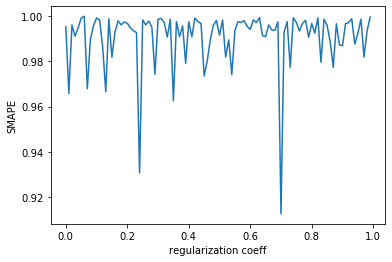

In [22]:
plot_data = pd.DataFrame({'regularization coeff' : pd.Series(np.arange(0, 1, 0.01)), 'SMAPE' : pd.Series(smapes)})
sns.lineplot(data=plot_data, x="regularization coeff", y='SMAPE')

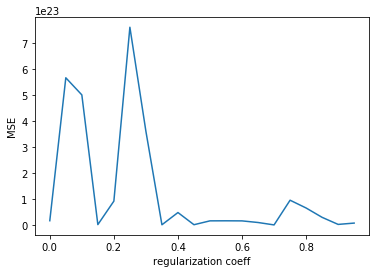

In [74]:
plot_data = pd.DataFrame({'regularization coeff' : pd.Series(np.arange(0, 1, 0.05)), 'MSE' : pd.Series(mses)})
sns.lineplot(data=plot_data, x="regularization coeff", y='MSE')

Постройте график зависимости экспоненциального скользящего среднего эмпирического риска на тренировочном множестве для градиентных спусков.


In [76]:
len(X_train)

1164

In [91]:
#     params = [lr, reg_coef, f_coef]
params_smape = [0.7620298911539111, 0.5268809022607328, 0.0073307146069250114]
params_mse = [0.0003219923006056728, 0.0004678581947714788, 0.6810141796169158]
    
smape_model = SGDClassifier(False, epochs_count=2, lr = 0.7620298911539111, reg_coef=0.5268809022607328, f_coef=0.0073307146069250114)
mse_model = SGDClassifier(True, epochs_count=2, lr=0.0003219923006056728, reg_coef=0.0004678581947714788, f_coef=0.6810141796169158)
    
smape_model.fit(X_train, y_train)
mse_model.fit(X_train, y_train)
print()

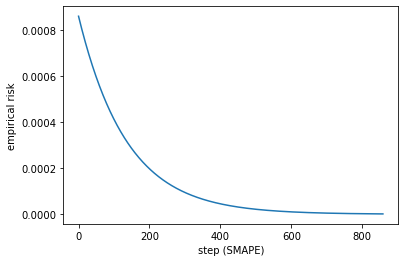

In [99]:
plot_data = pd.DataFrame({'step (SMAPE)': np.arange(0, 859, 1), 'empirical risk': smape_model.get_empirical_risk_storage()})
sns.lineplot(data=plot_data, x= 'step (SMAPE)', y= 'empirical risk')

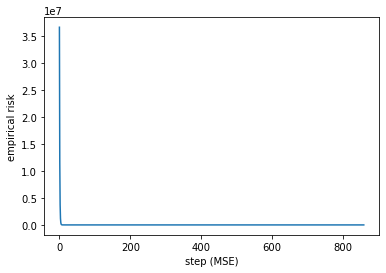

In [100]:
plot_data = pd.DataFrame({'step (MSE)': np.arange(0, 859, 1), 'empirical risk': mse_model.get_empirical_risk_storage()})
sns.lineplot(data=plot_data, x= 'step (MSE)', y= 'empirical risk')

Оцените каждый из трёх методов на тестовом множестве данных при помощи NRMSE и SMAPE.

In [101]:
ls_model = LSClassifier(0.12980080512766853)
ls_model.fit(X_train, y_train)

In [106]:
y_predicted = ls_model.predict(X_test)
ls_nrmse = calc_nrmse(y_predicted, y_test)
ls_smape = calc_smape(y_predicted, y_test)

In [107]:
print('Least Squares NRMSE', ls_nrmse)
print('Least Squares SMAPE', ls_smape)

Least Squares NRMSE 0.9005724470332871
Least Squares SMAPE 0.8935805218336959


In [108]:
y_predicted = smape_model.predict(X_test)
smape_model_nrmse = calc_nrmse(y_predicted, y_test)
smape_model_smape = calc_smape(y_predicted, y_test)

In [109]:
print('SGD (SMAPE) NRMSE', smape_model_nrmse)
print('SGD (SMAPE) SMAPE', smape_model_smape)

SGD (SMAPE) NRMSE 0.027192318314495464
SGD (SMAPE) SMAPE 0.7656533892727279


In [110]:
y_predicted = mse_model.predict(X_test)
mse_model_nrmse = calc_nrmse(y_predicted, y_test)
mse_model_smape = calc_smape(y_predicted, y_test)

In [111]:
print('SGD (SMAPE) NRMSE', mse_model_nrmse)
print('SGD (SMAPE) SMAPE', mse_model_smape)

SGD (SMAPE) NRMSE 0.030061132381747162
SGD (SMAPE) SMAPE 0.9996524711067802
